In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm

import matplotlib.pyplot as plt

# set gpu as default device
torch.set_default_device("cuda")

In [2]:
class RidgeRegressor(nn.Module):
    def __init__(self, noise_variance: float = 0.0):
        super().__init__()
        self.noise_variance = noise_variance

    def forward(self, X, y):
        n_samples, n_dim = X.shape
        ones = torch.ones(n_samples, 1, device=X.device)
        X = torch.concat([X, ones], dim=-1) # add bias

        if n_samples >= n_dim:
            # standard
            A = X.T@X
            A.diagonal().add_(self.noise_variance)
            B = X.T@y
            weights = torch.linalg.solve(A, B)
        else:
            # Woodbury
            A = X@X.T
            A.diagonal().add_(self.noise_variance)
            weights = X.T@torch.linalg.solve(A, y)
            
        w = weights[:-1].reshape(-1, 1)
        b = weights[-1].reshape(1, 1)

        return w, b # (n_dim, 1), (1, 1)

class SIREN(nn.Module):
    def __init__(self, input_dim: int, output_dim: int, layers: list, activation_scale: float, dropout: float):
        super().__init__()

        self.activation_scale = activation_scale
        self.dropout = dropout

        self.input_layer = nn.Linear(input_dim, layers[0])
        self.layers = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers)-1)])
        self.output_layer = nn.Linear(layers[-1], output_dim)

    def forward(self, x):
        out = self.input_layer(x)
        out = torch.sin(self.activation_scale * out)
        for layer in self.layers:
            out = layer(out)
            out = torch.sin(self.activation_scale * out)
            out = F.dropout(out, p=self.dropout, training=self.training)
        out = self.output_layer(out)
        return out

def get_initialized_model(input_dim, output_dim, layers, activation_scale, dropout):
    def first_layer_init(m):
        if hasattr(m, 'weight'):
            input_size = m.weight.size(-1)
            m.weight.uniform_(-1 / input_size, 1 / input_size)

    def other_layer_init(m):
        if hasattr(m, 'weight'):
            input_size = m.weight.size(-1)
            m.weight.uniform_(-np.sqrt(6 / input_size) / activation_scale, np.sqrt(6 / input_size) / activation_scale)

    model = SIREN(input_dim, output_dim, layers, activation_scale, dropout)
    with torch.no_grad():
        model.input_layer.apply(first_layer_init)
        model.layers.apply(other_layer_init)
        model.output_layer.apply(other_layer_init)

    return model

In [25]:
class Data_Generator:
    def __init__(self, N,lookback_window,lookahead_window, f, noise_std):
        self.N = N
        self.x = torch.linspace(0,1, N).reshape(-1,1)
        self.f = f
        self.x_train = self.x[:N//2]
        self.noise_std = noise_std
        self.y_train = f(self.x_train) + self.noise_std * torch.randn(N//2, 1)
        self.x_test = self.x[N//2:]
        self.lookback_window = lookback_window
        self.lookahead_window = lookahead_window
    
    def plot_train (self):
        plt.figure(figsize=(12, 3))
        plt.plot(self.x.cpu(), self.f(self.x).cpu(), 'r--', label='f(x)')
        plt.plot(self.x_train.cpu(), self.y_train.cpu(), 'bo', label='train', markersize=2)
        plt.legend()
        plt.show()

    def data_seq_prep(self, lookback_window, lookahead_window):
        y_lookback = []
        y_lookahead = []
        for i in range(lookback_window, len(self.x_train)-lookahead_window+1):
            y_lookback.append(self.y_train[i-lookback_window:i][np.newaxis, ...])
            y_lookahead.append(self.y_train[i:i+lookahead_window][np.newaxis, ...])

        y_lookback = torch.cat(y_lookback, dim=0)
        y_lookahead = torch.cat(y_lookahead, dim=0)

        return y_lookback, y_lookahead

    def one_example_forward_pass(self, y_input, mode): # y_input: (lookback_window, 1), y_output: (lookahead_window, 1)
            lookback_window = self.lookback_window
            lookahead_window = self.lookahead_window
            if mode == "train":
                self.siren.train()
                self.ridge_reg.train()
            else:
                self.siren.eval()
                self.ridge_reg.eval()
                
            coords = torch.linspace(0, 1, lookback_window+lookahead_window).reshape(-1, 1)
            time_repr = self.siren(coords)
            lookback_repr = time_repr[:lookback_window]
            lookahead_repr = time_repr[-lookahead_window:]
            
            w, b = self.ridge_reg(lookback_repr, y_input)
            y_pred = lookahead_repr@w + b
            
            return y_pred

    def train(self, lookback_window, lookahead_window):
        self.siren = get_initialized_model(1, 16, [256, 256], 30.0, 0.0)
        self.ridge_reg = RidgeRegressor(noise_variance=1e-4)
        y_lookback, y_lookahead = self.data_seq_prep(lookback_window, lookahead_window)
    
        forward_pass = torch.vmap(self.one_example_forward_pass, in_dims=(0, None), out_dims=0, randomness="different")

        optimizer = torch.optim.Adam(self.siren.parameters(), lr=1e-3)
        epochs = 500

        pbar = tqdm(range(epochs))
        losses = []

        for i in pbar:
            optimizer.zero_grad()
            y_lookahead_pred = forward_pass(y_lookback, "train")
            loss = F.mse_loss(y_lookahead_pred, y_lookahead)
            loss.backward()
            optimizer.step()
            pbar.set_description(f'Loss: {loss.item():.4f}')
            losses.append(loss.item())
            
        plt.plot(losses)

    def testing_plot(self):
        print(self.x_train.shape, self.y_train.shape, self.x.shape)
        lookback_window = self.lookback_window
        lookahead_window = self.lookahead_window
        with torch.no_grad():
            y_pred = self.one_example_forward_pass(self.y_train[-lookback_window:], mode="test")
            print(y_pred.shape)

        plt.figure(figsize=(12, 3))
        plt.plot(self.x.cpu(), self.f(self.x).cpu(), label='f');
        plt.plot(self.x_train.cpu(), self.y_train.cpu(), 'o', label='train', markersize=2);
        plt.plot(self.x_train[-lookback_window:].cpu(), self.y_train[-lookback_window:].cpu(), label='lookback');
        plt.plot(self.x_test.cpu()[:lookahead_window], y_pred.cpu(), label='forward prediction');
        plt.legend();


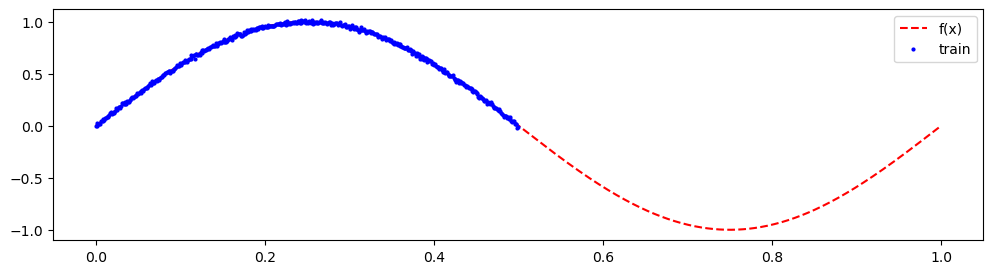

Loss: 0.0462: 100%|██████████| 500/500 [00:02<00:00, 215.27it/s]


torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([1000, 1])
torch.Size([128, 1])


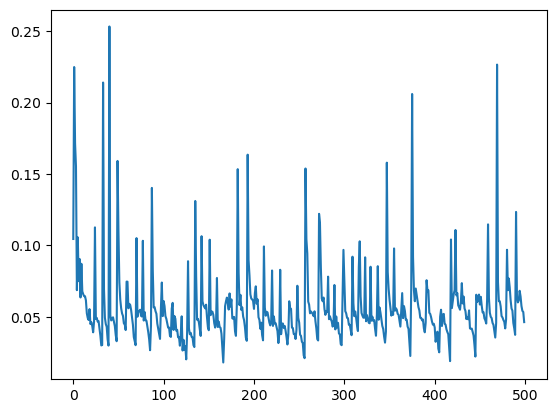

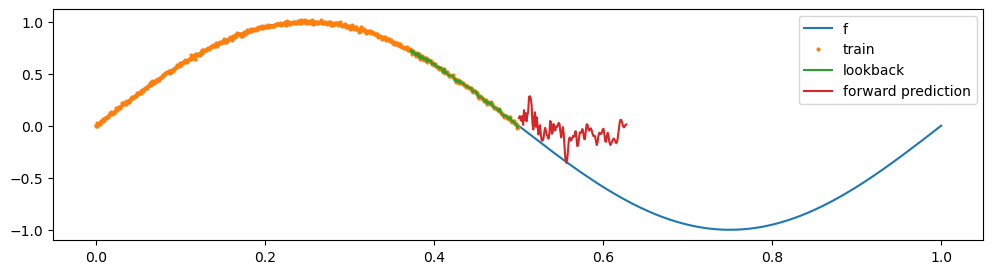

In [28]:
data = Data_Generator(1000,128, 128, lambda x: torch.sin(2*np.pi*x), 0.01)
data.plot_train()
data.train(lookback_window=128, lookahead_window=128)
data.testing_plot()

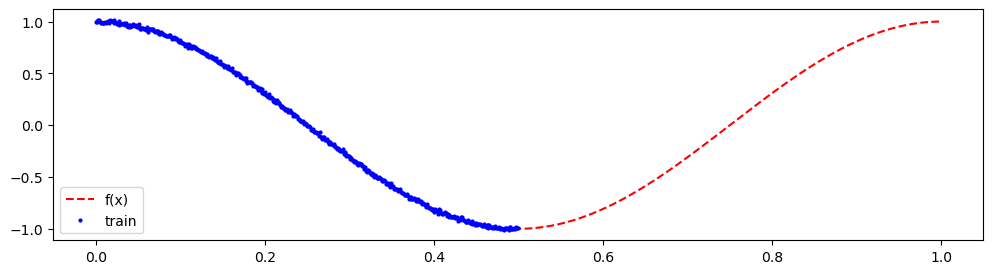

Loss: 0.0002: 100%|██████████| 500/500 [00:02<00:00, 216.57it/s]


torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([1000, 1])
torch.Size([128, 1])


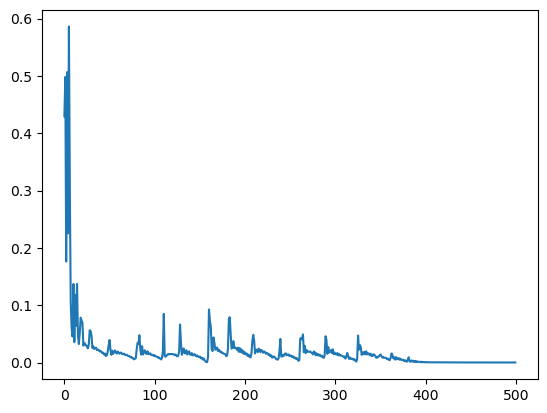

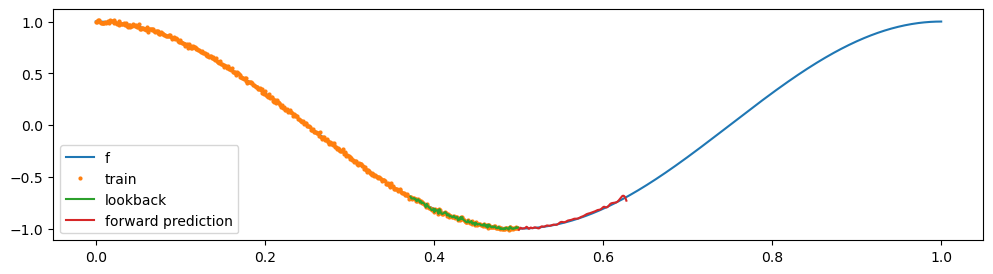

In [27]:
data = Data_Generator(1000,128, 128, lambda x: torch.cos(2*np.pi*x), 0.01)
data.plot_train()
data.train(lookback_window=128, lookahead_window=128)
data.testing_plot()

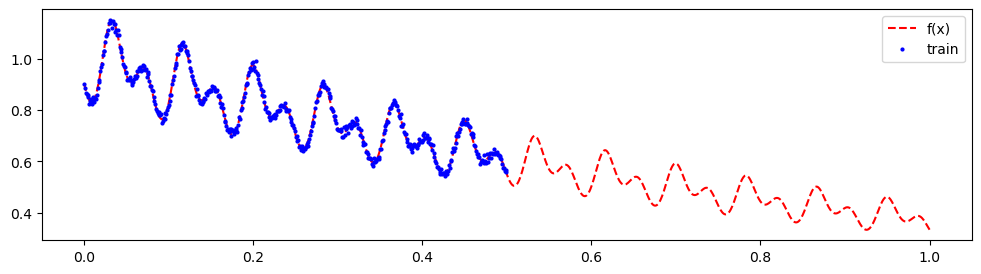

Loss: 0.0001: 100%|██████████| 500/500 [00:02<00:00, 222.73it/s]


torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([1000, 1])
torch.Size([128, 1])


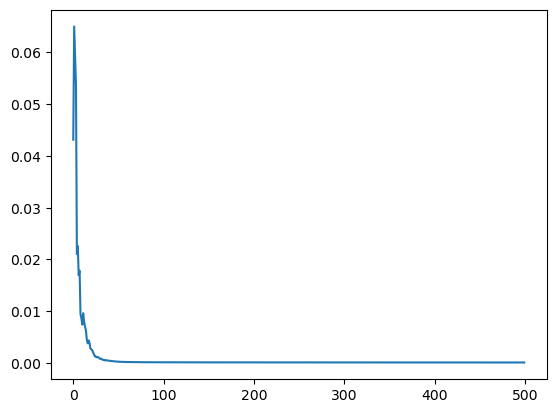

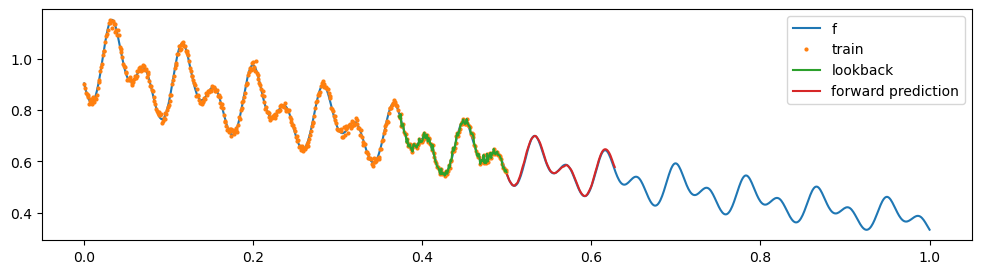

In [31]:
data = Data_Generator(1000,128, 128, lambda x: torch.exp(-(torch.sin(48 * np.pi * x) + torch.cos(24 * np.pi * x) + 10*x)/10), 0.01)
data.plot_train()
data.train(lookback_window=128, lookahead_window=128)
data.testing_plot()

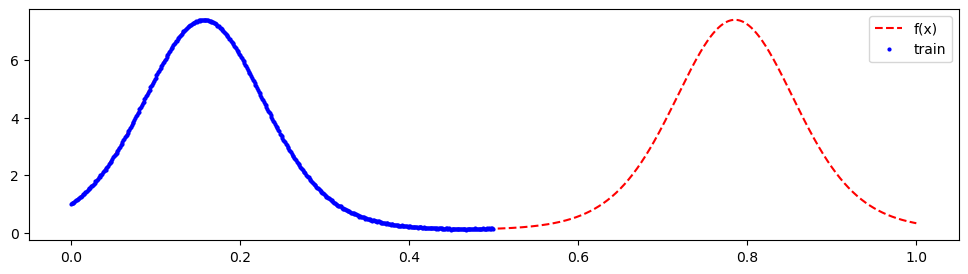

Loss: 4.9166: 100%|██████████| 500/500 [00:02<00:00, 217.63it/s] 


torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([1000, 1])
torch.Size([128, 1])


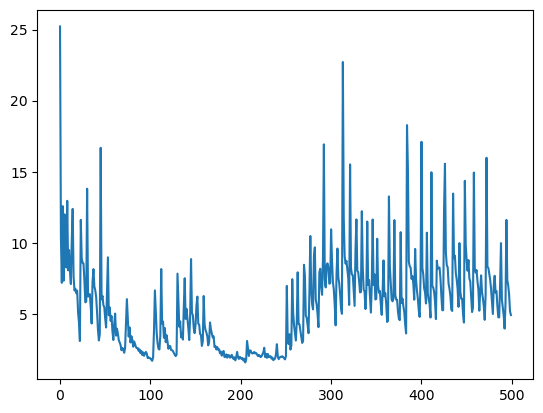

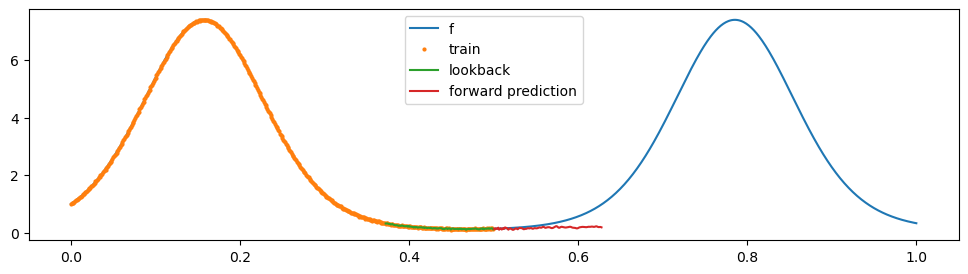

In [33]:
data = Data_Generator(1000,128, 128, lambda x: torch.exp(2*torch.sin(10*x)), 0.01)
data.plot_train()
data.train(lookback_window=128, lookahead_window=128)
data.testing_plot()

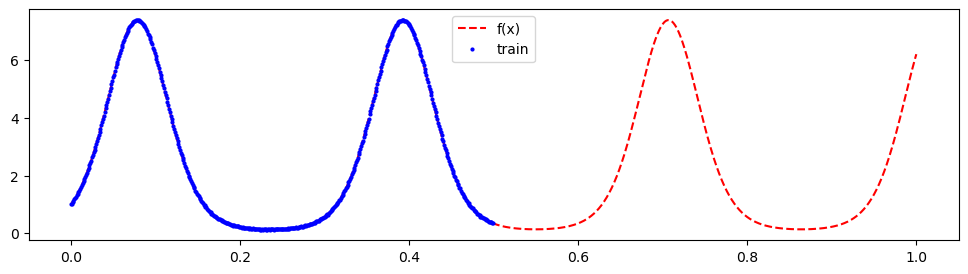

Loss: 6.3372: 100%|██████████| 500/500 [00:02<00:00, 220.93it/s] 


torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([1000, 1])
torch.Size([128, 1])


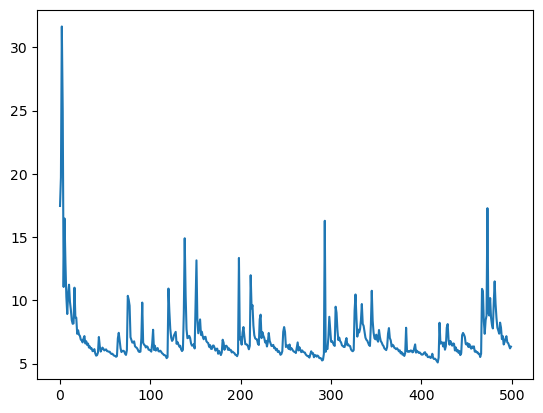

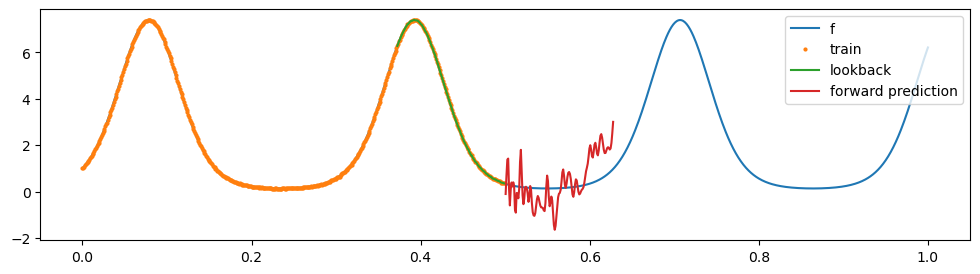

In [34]:
data = Data_Generator(1000,128, 128, lambda x: torch.exp(2*torch.sin(20*x)), 0.01)
data.plot_train()
data.train(lookback_window=128, lookahead_window=128)
data.testing_plot()

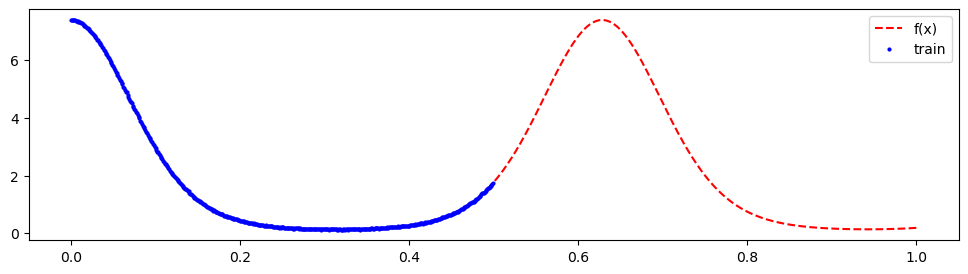

Loss: 0.0359: 100%|██████████| 500/500 [00:02<00:00, 221.10it/s]


torch.Size([500, 1]) torch.Size([500, 1]) torch.Size([1000, 1])
torch.Size([128, 1])


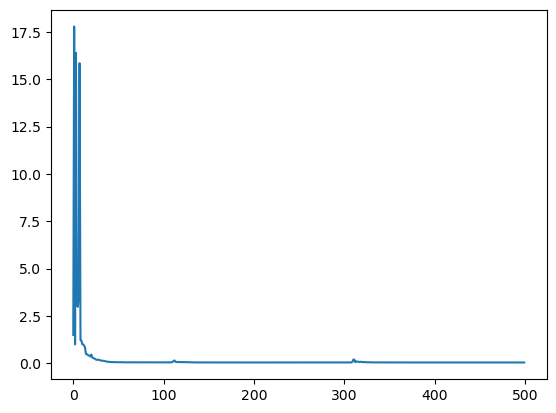

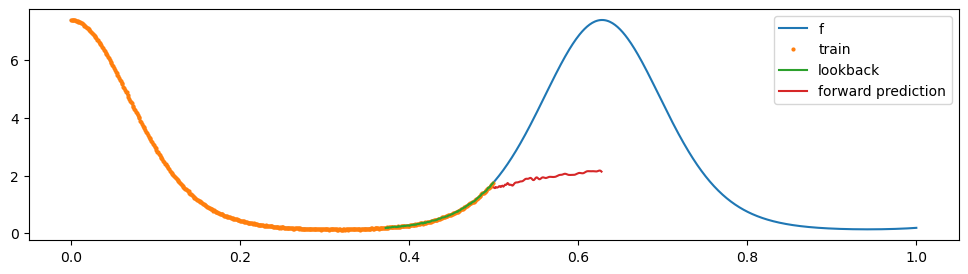

In [35]:
data = Data_Generator(1000,128, 128, lambda x: torch.exp(2*torch.cos(10*x)), 0.01)
data.plot_train()
data.train(lookback_window=128, lookahead_window=128)
data.testing_plot()